## Group Member: Jeffery Zhang, Oliver Liu, Zhe Zhou

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
import datetime
import calendar
import statistics

### EDA

* ##### Some of the columns contain lists and dictionaries. Extract information you need and reformat them. -- Zhe Zhou

In [2]:
# Read the data from the file, and create a DataFrame object.
raw_data_movies = pd.read_csv("tmdb_5000_movies.csv")

In [3]:
# Reformat the columns contain dictionaries as a string list.
raw_data_movies["genres"] = raw_data_movies["genres"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["keywords"] = raw_data_movies["keywords"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["production_companies"] = raw_data_movies["production_companies"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["production_countries"] = raw_data_movies["production_countries"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["spoken_languages"] = raw_data_movies["spoken_languages"].apply(lambda x : [i["name"] for i in eval(x)])

In [4]:
# Read the data from the file, and create a DataFrame object.
raw_data_credits = pd.read_csv("tmdb_5000_credits.csv")

In [5]:
# Reformat the columns contain dictionaries as a string list.
raw_data_credits["cast"] = raw_data_credits["cast"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_credits["crew"] = raw_data_credits["crew"].apply(lambda x : [i["job"] + " : " + i["name"] for i in eval(x)])

In [6]:
# Merge two datasets base on the movies' id number, and drop the duplicated columns.
raw_data = pd.merge(raw_data_movies, raw_data_credits.drop("title", 1), left_on = "id", right_on = "movie_id").drop("movie_id", 1)

* ##### Clean the dataset, remove the outliers, before any data analysis. Explain what you did. -- Zhe Zhou

In [7]:
# Clean the dataset, and remove the outliers.
data = raw_data[(raw_data["budget"] > 0) &
                (raw_data["original_title"] is not np.nan) &
                (raw_data["popularity"] > 0) & 
                (raw_data["production_companies"].apply(len) != 0) &
                (raw_data["production_countries"].apply(len) != 0) & 
                (raw_data["release_date"] is not np.nan) &
                (raw_data["revenue"] > 0) &
                (raw_data["runtime"] > 0) &
                (raw_data["cast"].apply(len) != 0) & 
                (raw_data["crew"].apply(len) != 0)]

In the process of cleaning the data, the outliers that are caused by artifacts have to be removed. The purpose of this project is to build the model of predicting the revenue of movies, so the values of budget and revenue are not supposed to be zero. Also, the runtime of the movies cannot be zero because it does not make sense. In addition, the columns, "original_title", "cast", and "crew", are necessary since they demonstrate the convincingness of the data. Furthermore, in the other columns, "production_companies" and "production_countries", all these data are required in the model that we are going to build. And now, we are able to begin our data analysis.

In [8]:
data.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,3.183000e+03,3183.000000,3183.000000,3.183000e+03,3183.000000,3183.000000,3183.000000
mean,4.113039e+07,44878.875589,29.415936,1.229086e+08,110.859881,6.315112,991.026076
std,4.450600e+07,75046.011568,36.283411,1.871212e+08,20.991509,0.868237,1419.826830
min,1.000000e+00,5.000000,0.037073,5.000000e+00,41.000000,0.000000,0.000000
25%,1.100000e+07,4884.500000,10.812450,1.770142e+07,96.000000,5.800000,189.000000
50%,2.600000e+07,11361.000000,20.786616,5.693230e+07,107.000000,6.300000,484.000000
75%,5.500000e+07,45038.500000,37.689512,1.487174e+08,121.000000,6.900000,1161.000000
max,3.800000e+08,417859.000000,875.581305,2.787965e+09,338.000000,8.500000,13752.000000


* ##### Count the number of movies released by day of week, month and year, are there any patterns that you observe? -- Oliver Liu

In [9]:
data['release_date']

0       2009-12-10
1       2007-05-19
2       2015-10-26
3       2012-07-16
4       2012-03-07
           ...    
4773    1994-09-13
4788    1972-03-12
4792    1997-11-06
4796    2004-10-08
4798    1992-09-04
Name: release_date, Length: 3183, dtype: object

In [10]:
days = []
for date in data['release_date']:
    day = calendar.day_name[datetime.datetime.strptime(date, '%Y-%m-%d').weekday()]
    days.append(day)
data["release_day_of_week"] = days
data
groupby_day = data.groupby('release_day_of_week').budget.count()
print(groupby_day.sort_values())

release_day_of_week
Sunday        112
Saturday      129
Monday        157
Tuesday       223
Wednesday     593
Thursday      665
Friday       1304
Name: budget, dtype: int64


<ipython-input-10-4c2d22df4d15>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["release_day_of_week"] = days


* ##### What are the movie genre trend shifting patterns that you can observe from the dataset? -- Jeffery Zhang

In [11]:
# Gets all genres in the dataset
unique_genre = {genre for l in data["genres"] for genre in l}
unique_genre

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western'}

In [12]:
# Gets the popularity of all genres including repeats different genres
all_info = {}
for ug in unique_genre:
    list = []
    for l in range (0,len(data["popularity"])):
        nextList = data["genres"].get(l)
        if (nextList is not None and ug in nextList):
            list.append(data["popularity"].get(l))
    all_info[ug] = list

In [13]:
# Removes any genre with no popularity
new_all_info = {key:val for key, val in all_info.items() if val}
new_all_info

{'Action': [150.437577,
  139.082615,
  107.376788,
  112.31295,
  43.926995,
  115.699814,
  134.279229,
  155.790452,
  57.925623,
  107.928811,
  145.847379,
  49.046956,
  99.398009,
  144.448633,
  135.413856,
  52.035179,
  120.965743,
  89.866276,
  37.668301,
  61.22601,
  198.372395,
  64.928382,
  418.708552,
  93.004993,
  35.149586,
  77.68208,
  3.857526,
  21.939663,
  116.840296,
  89.270217,
  73.79505,
  51.872839,
  71.862892,
  102.322217,
  81.834855,
  118.078691,
  78.291018,
  43.349855,
  62.169881,
  56.523205,
  28.529607,
  75.674458,
  125.114374,
  65.352913,
  22.57178,
  45.274225,
  85.36908,
  42.741719,
  187.322927,
  120.725053,
  40.748915,
  60.034162,
  90.23792,
  79.456485,
  44.640292,
  32.852443,
  77.300194,
  110.620647,
  243.791743,
  41.796339,
  72.225265,
  203.73459,
  48.775723,
  69.405188,
  481.098624,
  167.58371,
  9.476999,
  108.849621,
  6.909942,
  3.195174,
  127.284427,
  35.580815,
  21.133748,
  63.148529,
  202.042635,


In [14]:
all_info = new_all_info
genres = [*all_info]
genres

['Action',
 'Comedy',
 'Family',
 'Adventure',
 'Romance',
 'History',
 'Documentary',
 'Animation',
 'Music',
 'Western',
 'Science Fiction',
 'War',
 'Thriller',
 'Drama',
 'Mystery',
 'Horror',
 'Fantasy',
 'Crime']

In [15]:
# Uses previous dictionary to get medians and means for each genre
medians = {}
means = {}

In [16]:
for g in genres:
    list = all_info.get(g)
    if(list):
        medians[g] = statistics.median(list)
        means[g] = statistics.mean(list)
median_values = [*medians.values()]
mean_values = [*means.values()]
median_val_rounded = [round(num,2) for num in median_values]
mean_val_rounded = [round(num,2) for num in mean_values]
#len(median_val_rounded)
#len(mean_val_rounded)

Text(0.5, 1.0, 'Median Popularities by Genre')

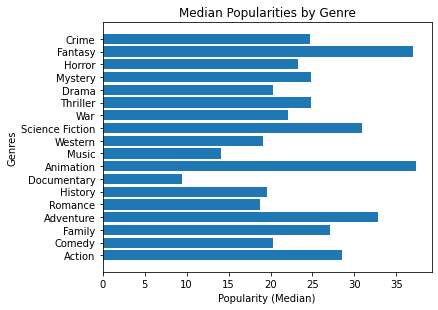

In [17]:
# Plot data
pyplt.barh(y=genres,width=median_val_rounded)
pyplt.tight_layout()
pyplt.xlabel("Popularity (Median)")
pyplt.ylabel("Genres")
pyplt.title("Median Popularities by Genre")

Text(0.5, 1.0, 'Mean Popularities by Genre')

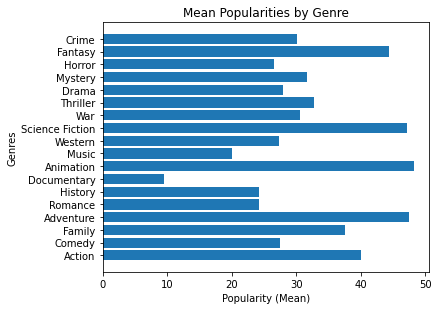

In [18]:
pyplt.barh(y=genres,width=mean_val_rounded)
pyplt.tight_layout()
pyplt.xlabel("Popularity (Mean)")
pyplt.ylabel("Genres")
pyplt.title("Mean Popularities by Genre")

Via my interpretation of the question, "What are the movie genre trend shifting patterns that you can observe from the dataset?", I started by understanding what trends are which are usually the most popular object which means dictates that trend shifting would imply an object in this case our object being movie genre that is farest away from the mean and medians. To get this information, I used the dataset to find all unique genres to find the popularity means and medians for each genre. AfterwardsI used the median and means by genre to visualize the results which displays that documentaries are the movie genre that shifts the movie genre trend pattern the most since it is by far the lowest in both median and mean compared to all other moviegenres.

* ##### What are the strongest and weakest features correlated with movie revenue? -- Oliver Liu

In [19]:
data.corr()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.012717,0.427822,0.703984,0.226795,-0.034135,0.537224
id,0.012717,1.000000,0.178044,0.029373,-0.033730,-0.064647,0.106548
popularity,0.427822,0.178044,1.000000,0.599706,0.179201,0.286779,0.747323
revenue,0.703984,0.029373,0.599706,1.000000,0.231085,0.187030,0.754761
runtime,0.226795,-0.033730,0.179201,0.231085,1.000000,0.382346,0.255873
vote_average,-0.034135,-0.064647,0.286779,0.187030,0.382346,1.000000,0.379500
vote_count,0.537224,0.106548,0.747323,0.754761,0.255873,0.379500,1.000000


<AxesSubplot:>

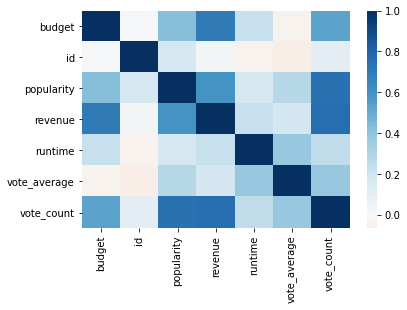

In [20]:
sns.heatmap(data.corr(), cmap='RdBu', center=0)

In [21]:
groupby_day_rev = data.groupby('release_day_of_week').revenue.agg(['count', 'median'])
print(groupby_day_rev.sort_values('median'))

                     count      median
release_day_of_week                   
Saturday               129  41158757.0
Friday                1304  42185535.5
Sunday                 112  44367120.5
Monday                 157  49469904.0
Tuesday                223  68896829.0
Thursday               665  77000000.0
Wednesday              593  86658558.0


By ranking, we see budget is the most correlated with revenue, followed by popularity and vote count.
Runtime is not very strongly correlated with revenue.
Correlation with vote average is suprisingly low.
Correlation with id is, as expected, very low.

### Modeling and Question Answering